# Paris neighbourhoods and suburbs exploration and clustering
This Notebook aims at exploring and clustering the Parisian neighbourhoods and suburbs with respect to the venues information available through Foursquare.

### Data Import and Preprocessing

First, let us import all the necessary libraries we'll be using for the study.

In [1]:
import sys

import pandas as pd # library for data analsysis
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

import numpy as np

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# import yellowbrick to apply and visualize the elbow method
from yellowbrick.cluster import KElbowVisualizer

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

# All requested packages already installed.

Libraries imported.


Import the zip codes data previously downloaded from the French governmental web site: https://www.data.gouv.fr/fr/datasets/base-officielle-des-codes-postaux/

In [2]:
zipc = pd.read_csv('laposte_hexasmal.csv',header=0, sep=';')
zipc.head()

,Code_commune_INSEE,Nom_commune,Code_postal,Ligne_5,Libellé_d_acheminement,coordonnees_gps
0,25628,VILLERS SOUS MONTROND,25620,NaN,VILLERS SOUS MONTROND,"47.1453733993,6.08965365162"
1,26001,SOLAURE EN DIOIS,26150,AIX EN DIOIS,SOLAURE EN DIOIS,"44.7024063065,5.38335100127"
2,26001,SOLAURE EN DIOIS,26150,MOLIERES GLANDAZ,SOLAURE EN DIOIS,"44.7024063065,5.38335100127"
3,26006,ALLEX,26400,NaN,ALLEX,"44.7665515552,4.91520351074"
4,26013,ARPAVON,26110,NaN,ARPAVON,"44.370914993,5.27351034083"


The GPS coordinates are stored in one column, because they had a different separator. Thus, ze split the coordinates column into two. This table also has many columns that we won't need, so we get rid of them and rename the others.

In [3]:
zipc['Latitude'], zipc['Longitude'] = zipc['coordonnees_gps'].str.split(',', 1).str
zipc.drop(['Code_commune_INSEE', 'Ligne_5', 'Libellé_d_acheminement', 'coordonnees_gps'], axis=1, inplace = True)
zipc.rename(columns = {'Nom_commune':'Name', 'Code_postal':'Zip_Code'}, inplace = True)
zipc.head()

,Name,Zip_Code,Latitude,Longitude
0,VILLERS SOUS MONTROND,25620,47.1453733993,6.08965365162
1,SOLAURE EN DIOIS,26150,44.7024063065,5.38335100127
2,SOLAURE EN DIOIS,26150,44.7024063065,5.38335100127
3,ALLEX,26400,44.7665515552,4.91520351074
4,ARPAVON,26110,44.370914993,5.27351034083


The table now contains only the necessary columns, but it still has too many rows: we downloaded wip codes for the whole France, whereas we will only be studying the Paris region. The region (or department in French to be precise) of a town or a neighbourhood is coded in the first two digits of its zip code, so let's extract those and add them to our table a new column.

In [4]:
def get_dep_num(zip_code): # function to extract the first two digits from a zip code
    s_code = str(zip_code)
    if len(s_code) < 5:
        s_code = '0' + s_code
    return int(s_code[0:2])

In [5]:
zipc['Department'] = zipc['Zip_Code'].apply(get_dep_num)
zipc.head()

,Name,Zip_Code,Latitude,Longitude,Department
0,VILLERS SOUS MONTROND,25620,47.1453733993,6.08965365162,25
1,SOLAURE EN DIOIS,26150,44.7024063065,5.38335100127,26
2,SOLAURE EN DIOIS,26150,44.7024063065,5.38335100127,26
3,ALLEX,26400,44.7665515552,4.91520351074,26
4,ARPAVON,26110,44.370914993,5.27351034083,26


The so called "Petite Couronne" of Paris consists of four departments: Paris intself (code 75), Hauts-de-Seine (code 92), Seine-Saint-Denis (93), and Val-de-Marne (94). Let's only choose the towns and boroughs in these departments.

In [6]:
# The Petite Couronne
paris_region_num = [75, 92, 93, 94]

In [7]:
zip_paris = zipc[zipc['Department'].isin(paris_region_num)] # choose only the Paris region departments
zip_paris = zip_paris.reset_index()
zip_paris.drop(['index'], axis=1, inplace = True)
zip_paris.drop_duplicates(subset = ['Name'], inplace = True) # drop duplicates (due to the input file)
print('Number of Towns and Boroughs: ' + str(zip_paris.shape[0]))
zip_paris.sort_values(by = 'Name')

Number of Towns and Boroughs: 144


,Name,Zip_Code,Latitude,Longitude,Department
23,ABLON SUR SEINE,94480,48.7238409464,2.42117629348,94
59,ALFORTVILLE,94140,48.7960843864,2.42124593241,94
96,ANTONY,92160,48.7503412602,2.2993268102,92
86,ARCUEIL,94110,48.8058803597,2.33351024984,94
97,ASNIERES SUR SEINE,92600,48.9153530123,2.2880384663,92
131,AUBERVILLIERS,93300,48.9121722626,2.38445513768,93
77,AULNAY SOUS BOIS,93600,48.9458384367,2.49329041687,93
70,BAGNEUX,92220,48.7983229866,2.30989995212,92
132,BAGNOLET,93170,48.8690836308,2.42274096688,93
54,BOBIGNY,93000,48.907688244,2.43863982727,93


### Foursquare data exploration
Connect to the Foursquare database

In [8]:
CLIENT_ID = 'LJZO500UG2WRLMIB3X3TAJLLZVKQURND3DXC3IARUPROJDZF' # my Foursquare ID
CLIENT_SECRET = 'Z5NKNMAJWV4JJKKB00PPALKOGREH4NPQYAMRMQOMXBQYAPEW' # my Foursquare Secret
VERSION = '20200627' # Foursquare API version today

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: LJZO500UG2WRLMIB3X3TAJLLZVKQURND3DXC3IARUPROJDZF
CLIENT_SECRET:Z5NKNMAJWV4JJKKB00PPALKOGREH4NPQYAMRMQOMXBQYAPEW


Create functions for requesting the Foursquare database

In [9]:
def get_venues(name, lat, lng, radius, limit):  
    print(name)
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        lat, 
        lng, 
        radius, 
        LIMIT)

    # make the GET request
    raw = requests.get(url).json()
    results = None
    try:
        results = raw["response"]['groups'][0]['items']
    except:
        print(f"A problem occured with parsing {raw} ")
    # return only relevant information for each nearby venue
    return results

In [10]:
def getNearbyVenues(names, latitudes, longitudes, radius, limit):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        results = get_venues(name, lat, lng, radius, limit)
        if not results:
            continue
        venues_list.append([(
        name, 
        lat, 
        lng, 
        v['venue']['name'], 
        v['venue']['location']['lat'], 
        v['venue']['location']['lng'],  
        v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
              'Neighbourhood Latitude', 
              'Neighbourhood Longitude', 
              'Venue', 
              'Venue Latitude', 
              'Venue Longitude', 
              'Venue Category']

    return(nearby_venues)

Set the maximal number of venues to charge (LIMIT) and the radius to search in meters (radius)

In [11]:
LIMIT = 100
radius = 1000

Get the venues for each of the boroughs

In [12]:
paris_venues = getNearbyVenues(names=zip_paris['Name'],
                               latitudes=zip_paris['Latitude'],
                               longitudes=zip_paris['Longitude'],
                               radius=radius, limit=LIMIT
                               )

PARIS 04
PARIS 07
PARIS 11
PARIS 15
PARIS 16
PARIS 20
BOIS COLOMBES
BOULOGNE BILLANCOURT
CHAVILLE
COURBEVOIE
LA GARENNE COLOMBES
LEVALLOIS PERRET
MALAKOFF
RUEIL MALMAISON
SCEAUX
SEVRES
LE BOURGET
COUBRON
MONTFERMEIL
NEUILLY SUR MARNE
PANTIN
LES PAVILLONS SOUS BOIS
VAUJOURS
ABLON SUR SEINE
CHAMPIGNY SUR MARNE
CHENNEVIERES SUR MARNE
FONTENAY SOUS BOIS
L HAY LES ROSES
JOINVILLE LE PONT
MAISONS ALFORT
ST MANDE
ST MAUR DES FOSSES
SUCY EN BRIE
VILLENEUVE ST GEORGES
PARIS 06
PARIS 12
PARIS 13
PARIS 18
PARIS 01
PARIS 05
PARIS 09
PARIS 10
PARIS 02
PARIS 03
PARIS 08
PARIS 14
PARIS 17
PARIS 19
CLAMART
GENNEVILLIERS
MEUDON
NANTERRE
BOBIGNY
LES LILAS
PIERREFITTE SUR SEINE
SEVRAN
VILLETANEUSE
ALFORTVILLE
CACHAN
CHARENTON LE PONT
CRETEIL
GENTILLY
NOISEAU
LA QUEUE EN BRIE
RUNGIS
VALENTON
VINCENNES
VITRY SUR SEINE
BAGNEUX
CHATILLON
MARNES LA COQUETTE
NEUILLY SUR SEINE
VAUCRESSON
VILLE D AVRAY
AULNAY SOUS BOIS
BONDY
DRANCY
LIVRY GARGAN
LE RAINCY
ROMAINVILLE
TREMBLAY EN FRANCE
VILLEMOMBLE
VILLEPINTE
ARCU

In [13]:
print('Number of venues:' + str(paris_venues.shape[0]))
paris_venues.head()

Number of venues:4372


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PARIS 04,48.854228282,2.35736193814,Aux Merveilleux de Fred,48.855686,2.356369,Dessert Shop
1,PARIS 04,48.854228282,2.35736193814,Chez Mademoiselle,48.854290,2.359810,Restaurant
2,PARIS 04,48.854228282,2.35736193814,Jardin de l'Hôtel de Sens,48.853842,2.358404,Garden
3,PARIS 04,48.854228282,2.35736193814,Maison Européenne de la Photographie,48.855128,2.358948,Art Museum
4,PARIS 04,48.854228282,2.35736193814,Le Peloton Café,48.855505,2.356034,Coffee Shop


In [14]:
venues_per_neighb = paris_venues[['Neighbourhood', 'Venue']].groupby('Neighbourhood').count()
venues_per_neighb

,Venue
Neighbourhood,
ABLON SUR SEINE,4
ALFORTVILLE,24
ANTONY,19
ARCUEIL,28
ASNIERES SUR SEINE,34
AUBERVILLIERS,18
AULNAY SOUS BOIS,15
BAGNEUX,13
BAGNOLET,22


The total number of venues varies from just a couple of venues for the smallest towns up to the maximal limit chosen in the beginning.

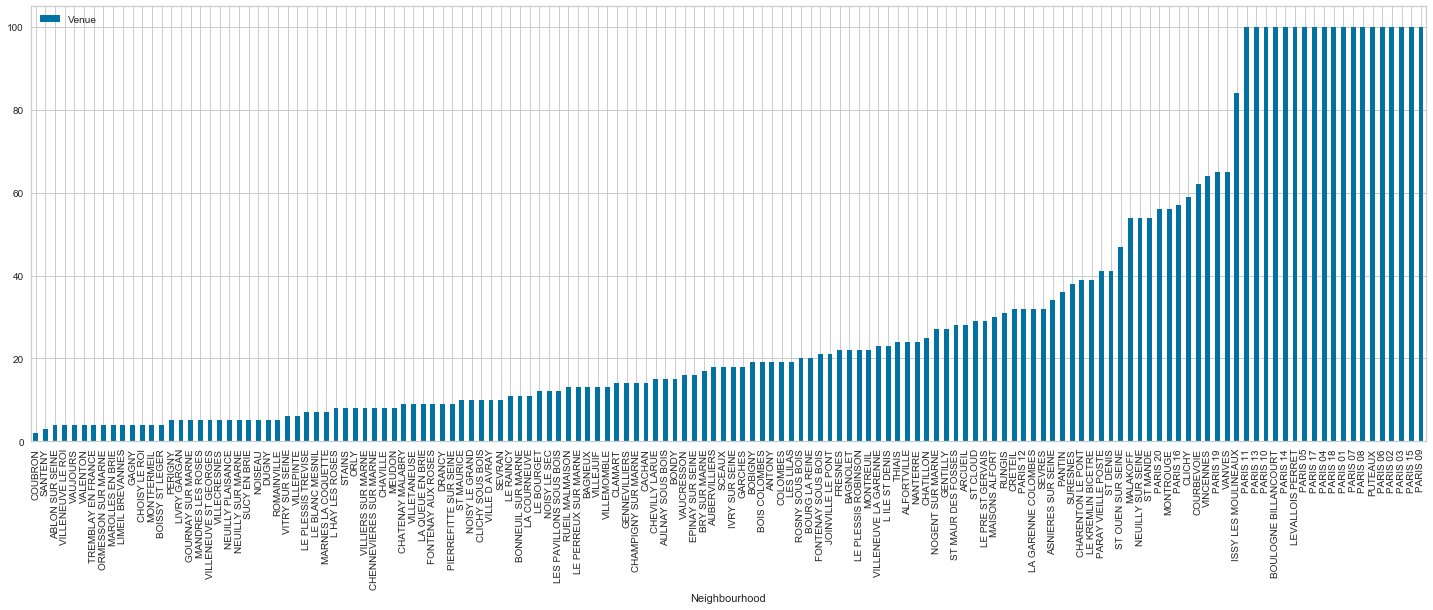

In [15]:
venues_per_neighb.sort_values(by='Venue').plot.bar(figsize=(25,8))
# plt.savefig('hist.png')

Let's select for the further study only the boroughs having 10 venues or more.

In [16]:
selected_venues = venues_per_neighb.Venue[venues_per_neighb.Venue >= 10]

In [17]:
sel_paris_venues = paris_venues[paris_venues['Neighbourhood'].isin(set(selected_venues.index))]
print(sel_paris_venues.shape)
sel_paris_venues.head()

(4116, 7)


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,PARIS 04,48.854228282,2.35736193814,Aux Merveilleux de Fred,48.855686,2.356369,Dessert Shop
1,PARIS 04,48.854228282,2.35736193814,Chez Mademoiselle,48.854290,2.359810,Restaurant
2,PARIS 04,48.854228282,2.35736193814,Jardin de l'Hôtel de Sens,48.853842,2.358404,Garden
3,PARIS 04,48.854228282,2.35736193814,Maison Européenne de la Photographie,48.855128,2.358948,Art Museum
4,PARIS 04,48.854228282,2.35736193814,Le Peloton Café,48.855505,2.356034,Coffee Shop


In [18]:
venues_per_neighb.Venue[venues_per_neighb.Venue >= 10].count()

100

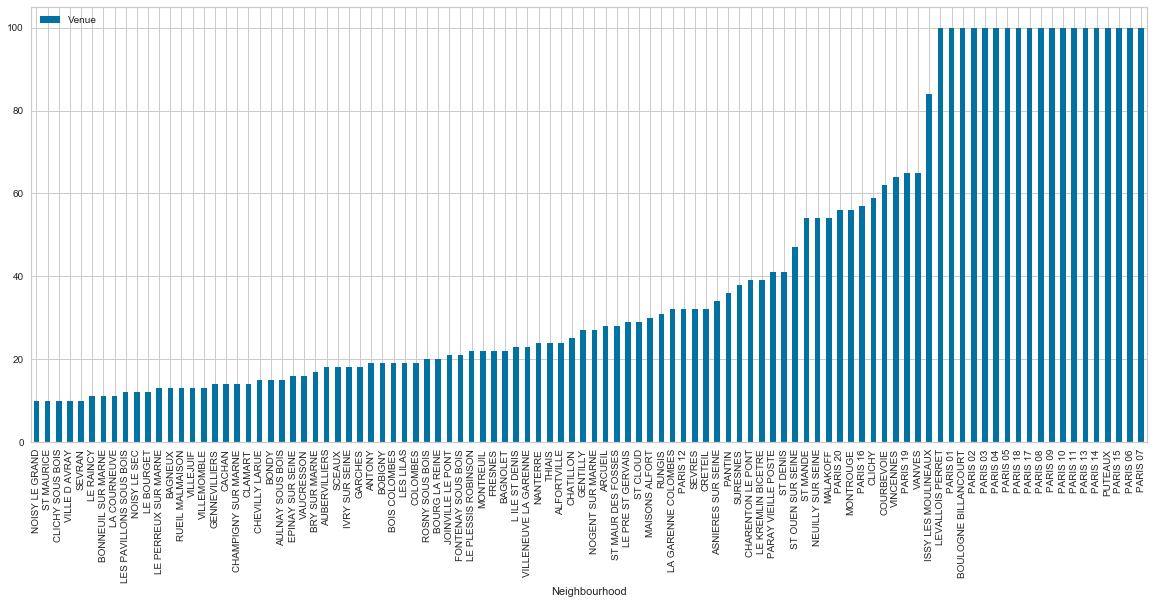

In [19]:
sel_paris_venues[['Neighbourhood', 'Venue']].groupby('Neighbourhood').count().sort_values(by='Venue').plot.bar(figsize=(20,8))

### Clustering
Prepare the features set

In [20]:
# one hot encoding
paris_onehot = pd.get_dummies(sel_paris_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot['Neighbourhood'] = sel_paris_venues['Neighbourhood'] 

# move neighborhood column to the first column
# get a list of columns
fixed_columns = list(paris_onehot)
# move the column to head of list using index, pop and insert
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighbourhood')))
paris_onehot = paris_onehot[fixed_columns]

paris_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,PARIS 04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,PARIS 04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,PARIS 04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,PARIS 04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PARIS 04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
print('There are {} unique categories.'.format(len(sel_paris_venues['Venue Category'].unique())))

There are 316 unique categories.


In [22]:
paris_grouped = paris_onehot.groupby('Neighbourhood').mean().reset_index()
paris_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,African Restaurant,Airport,Airport Lounge,Airport Service,Airport Terminal,Airport Tram,American Restaurant,...,Udon Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Vineyard,Wine Bar,Wine Shop,Women's Store,Yoga Studio,Zoo,Zoo Exhibit
0,ALFORTVILLE,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0
1,ANTONY,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0
2,ARCUEIL,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0
3,ASNIERES SUR SEINE,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0
4,AUBERVILLIERS,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0
5,AULNAY SOUS BOIS,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0
6,BAGNEUX,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0
7,BAGNOLET,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0
8,BOBIGNY,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0
9,BOIS COLOMBES,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0000,...,0.0,0.00,0.000000,0.00,0.00,0.000000,0.0,0.00,0.0,0.0


Take a look at the top five venues for each borough

In [23]:
num_top_venues = 5

for hood in paris_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = paris_grouped[paris_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALFORTVILLE----
                  venue  freq
0              Bus Stop  0.17
1     Convenience Store  0.08
2  Fast Food Restaurant  0.08
3      Asian Restaurant  0.08
4            Shoe Store  0.04


----ANTONY----
                 venue  freq
0    French Restaurant  0.11
1          Supermarket  0.11
2                 Park  0.11
3  Moroccan Restaurant  0.05
4        Train Station  0.05


----ARCUEIL----
              venue  freq
0    Sandwich Place  0.07
1             Hotel  0.07
2  Sushi Restaurant  0.07
3       Supermarket  0.07
4    Clothing Store  0.07


----ASNIERES SUR SEINE----
                 venue  freq
0          Supermarket  0.09
1  Japanese Restaurant  0.09
2               Market  0.06
3                Hotel  0.06
4               Bakery  0.06


----AUBERVILLIERS----
              venue  freq
0      Soccer Field  0.11
1            Bakery  0.06
2  Department Store  0.06
3              Park  0.06
4       Gas Station  0.06


----AULNAY SOUS BOIS----
                  venue  

                 venue  freq
0          Supermarket  0.18
1    Food & Drink Shop  0.09
2  Japanese Restaurant  0.09
3               Market  0.09
4     Sushi Restaurant  0.09


----LES LILAS----
                  venue  freq
0        Tennis Stadium  0.05
1                Circus  0.05
2         Movie Theater  0.05
3  Fast Food Restaurant  0.05
4      Sushi Restaurant  0.05


----LES PAVILLONS SOUS BOIS----
                venue  freq
0  Light Rail Station  0.17
1    Sushi Restaurant  0.17
2                Bank  0.08
3               Canal  0.08
4         Auto Garage  0.08


----LEVALLOIS PERRET----
               venue  freq
0  French Restaurant  0.11
1        Supermarket  0.07
2              Hotel  0.06
3                Bar  0.04
4             Bistro  0.04


----MAISONS ALFORT----
               venue  freq
0               Park  0.10
1        Supermarket  0.10
2           Creperie  0.07
3        Pizza Place  0.07
4  French Restaurant  0.03


----MALAKOFF----
                 venue  freq


                 venue  freq
0          Supermarket  0.18
1               Bakery  0.07
2                 Café  0.07
3     Sushi Restaurant  0.07
4  Japanese Restaurant  0.07


----ST MAURICE----
         venue  freq
0    Racetrack   0.1
1  Supermarket   0.1
2          Bar   0.1
3         Lake   0.1
4        Diner   0.1


----ST OUEN SUR SEINE----
               venue  freq
0  French Restaurant  0.13
1              Hotel  0.09
2        Supermarket  0.06
3                Bar  0.06
4             Bakery  0.06


----SURESNES----
                 venue  freq
0    French Restaurant  0.11
1                  Pub  0.05
2                Hotel  0.05
3  Japanese Restaurant  0.05
4                 Park  0.05


----THIAIS----
                    venue  freq
0                Bus Stop  0.17
1       Electronics Store  0.08
2  Furniture / Home Store  0.08
3          Clothing Store  0.08
4          Ice Cream Shop  0.04


----VANVES----
                 venue  freq
0    French Restaurant  0.12
1          P

In [24]:
def return_most_common_venues(row, num_top_venues): #function defining the top venues
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [25]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = paris_grouped['Neighbourhood']

for ind in np.arange(paris_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(paris_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALFORTVILLE,Bus Stop,Fast Food Restaurant,Convenience Store,Asian Restaurant,Pool,Train Station,Middle Eastern Restaurant,Flower Shop,Big Box Store,Shoe Store
1,ANTONY,French Restaurant,Supermarket,Park,Moroccan Restaurant,Bar,Optical Shop,Restaurant,Train Station,Bakery,Mobile Phone Shop
2,ARCUEIL,Sandwich Place,Clothing Store,Sushi Restaurant,Hotel,Supermarket,Steakhouse,Japanese Restaurant,Garden Center,Garden,Bookstore
3,ASNIERES SUR SEINE,Japanese Restaurant,Supermarket,French Restaurant,Bakery,Market,Hotel,Theater,Tennis Court,Bagel Shop,Fruit & Vegetable Store
4,AUBERVILLIERS,Soccer Field,Park,Fast Food Restaurant,Coffee Shop,Market,Supermarket,Bus Stop,Basketball Stadium,French Restaurant,Bakery
5,AULNAY SOUS BOIS,Hotel,Fast Food Restaurant,Supermarket,Pizza Place,Farm,Market,Bus Stop,Park,Asian Restaurant,Comedy Club
6,BAGNEUX,Bus Stop,Japanese Restaurant,Plaza,Gym / Fitness Center,Gas Station,Farmers Market,Construction & Landscaping,Discount Store,Distillery,Doner Restaurant
7,BAGNOLET,Park,French Restaurant,Breakfast Spot,Hotel,Coffee Shop,Electronics Store,Market,Supermarket,Bar,Bakery
8,BOBIGNY,Tram Station,Supermarket,Fast Food Restaurant,Soccer Field,Rental Service,Mobile Phone Shop,Comedy Club,Italian Restaurant,Stadium,Performing Arts Venue
9,BOIS COLOMBES,Supermarket,Japanese Restaurant,Farmers Market,Market,Bakery,Sandwich Place,Sushi Restaurant,Park,Creperie,French Restaurant


In [26]:
paris_grouped_clustering = paris_grouped.drop(['Neighbourhood'], axis = 1)

C:\Users\mrzay\Anaconda3\lib\site-packages\yellowbrick\utils\kneed.py:140: YellowbrickWarning: No 'knee' or 'elbow point' detected This could be due to bad clustering, no actual clusters being formed etc.
  warnings.warn(warning_message, YellowbrickWarning)
C:\Users\mrzay\Anaconda3\lib\site-packages\yellowbrick\cluster\elbow.py:343: YellowbrickWarning: No 'knee' or 'elbow' point detected, pass `locate_elbow=False` to remove the warning
  warnings.warn(warning_message, YellowbrickWarning)


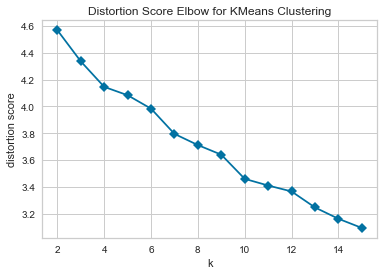

In [27]:
model = KElbowVisualizer(KMeans(random_state=0), k=15, timings=False)
model.fit(paris_grouped_clustering)
model.show()

In [28]:
# set number of clusters
kclusters = 5 # model_supercat.elbow_value_

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 3, 3, 2, 3, 0, 2, 0, 3, 2, 3, 3, 1, 2, 3, 3, 0, 0, 2, 0, 2, 0,
       3, 3, 0, 3, 3, 3, 3, 3, 4, 3, 0, 2, 0, 3, 4, 2, 3, 0, 1, 0, 0, 2,
       3, 3, 0, 3, 2, 3, 0, 3, 1, 3, 3, 3, 0, 3, 1, 1, 3, 1, 1, 1, 1, 0,
       1, 1, 1, 0, 3, 1, 1, 1, 1, 1, 1, 1, 0, 0, 2, 0, 3, 3, 2, 0, 3, 0,
       2, 3, 0, 0, 3, 0, 3, 1, 2, 3, 3, 1])

In [29]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged = zip_paris

# merge paris_grouped with paris_data to add latitude/longitude for each neighborhood
paris_merged = paris_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), \
                                                   on='Name', how='right')

paris_merged # check the last columns!

,Name,Zip_Code,Latitude,Longitude,Department,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PARIS 04,75004,48.854228282,2.35736193814,75,1,French Restaurant,Plaza,Ice Cream Shop,Cocktail Bar,Wine Bar,Hotel,Bookstore,Cultural Center,Park,Tea Room
1,PARIS 07,75007,48.8560825982,2.31243868773,75,1,French Restaurant,Hotel,Plaza,Italian Restaurant,Historic Site,Coffee Shop,Cocktail Bar,History Museum,Café,Garden
2,PARIS 11,75011,48.8594154976,2.37874106024,75,1,French Restaurant,Restaurant,Bar,Bistro,Cocktail Bar,Café,Pizza Place,Italian Restaurant,Wine Bar,Bakery
3,PARIS 15,75015,48.8401554186,2.29355937244,75,1,French Restaurant,Hotel,Italian Restaurant,Persian Restaurant,Korean Restaurant,Bakery,Japanese Restaurant,Coffee Shop,Lebanese Restaurant,Thai Restaurant
4,PARIS 16,75116,48.8603987604,2.2620995594,75,1,French Restaurant,Bakery,Italian Restaurant,Park,Japanese Restaurant,Art Museum,Supermarket,Plaza,Garden,Lake
5,PARIS 20,75020,48.8631867774,2.40081982673,75,1,Bar,French Restaurant,Bakery,Music Venue,Theater,Bistro,Café,Beer Bar,Tapas Restaurant,Japanese Restaurant
6,BOIS COLOMBES,92270,48.9153368426,2.26738552597,92,2,Supermarket,Japanese Restaurant,Farmers Market,Market,Bakery,Sandwich Place,Sushi Restaurant,Park,Creperie,French Restaurant
7,BOULOGNE BILLANCOURT,92100,48.8365843138,2.23913599058,92,1,French Restaurant,Italian Restaurant,Japanese Restaurant,Bakery,Burger Joint,Kebab Restaurant,Creperie,Market,Thai Restaurant,Restaurant
9,COURBEVOIE,92400,48.8984504771,2.25570587289,92,0,French Restaurant,Hotel,Supermarket,Plaza,Japanese Restaurant,Italian Restaurant,Pizza Place,Stadium,Bakery,Bus Stop
10,LA GARENNE COLOMBES,92250,48.9067577111,2.24464604084,92,2,Japanese Restaurant,French Restaurant,Pizza Place,Creperie,Lounge,Market,Supermarket,Sushi Restaurant,Cafeteria,Bank


In [30]:
latitude = paris_merged.loc[paris_merged['Name']=='PARIS 01','Latitude'].astype(float)
longitude = paris_merged.loc[paris_merged['Name']=='PARIS 01','Longitude'].astype(float)

# create map
map_clusters = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged['Latitude'].astype(float), paris_merged['Longitude'].astype(float), \
                                  paris_merged['Name'], paris_merged['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

Yellowbrick is either unable to detect an elbow on these data, or detects one that is not evident at all. This means that the data do not represent distinct clusters. My hypothesis is that this issue can be treated by regrouping the venue categories into much bigger super-categories, for example, 'Burgundian Restaurant', 'Savoyard Restaurant', and 'Breton Restaurant' would all go the 'French Restaurant' super category.

In [31]:
paris_merged.loc[paris_merged['Cluster Labels'] == 0, \
                     paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,COURBEVOIE,0,French Restaurant,Hotel,Supermarket,Plaza,Japanese Restaurant,Italian Restaurant,Pizza Place,Stadium,Bakery,Bus Stop
11,LEVALLOIS PERRET,0,French Restaurant,Supermarket,Hotel,Pizza Place,Sandwich Place,Bistro,Bar,Park,Clothing Store,Farmers Market
20,PANTIN,0,French Restaurant,Hotel,Bar,Supermarket,Auto Garage,Fried Chicken Joint,Restaurant,Steakhouse,Café,Dance Studio
24,CHAMPIGNY SUR MARNE,0,Supermarket,French Restaurant,Fast Food Restaurant,Miscellaneous Shop,Farmers Market,Wine Shop,Bakery,Hotel,Smoke Shop,Skating Rink
28,JOINVILLE LE PONT,0,Supermarket,Hotel,Plaza,Train Station,Japanese Restaurant,Gas Station,French Restaurant,Intersection,Bakery,Sushi Restaurant
30,ST MANDE,0,French Restaurant,Supermarket,Italian Restaurant,Japanese Restaurant,Pizza Place,Asian Restaurant,Bakery,Hotel,Bus Stop,Tennis Stadium
35,PARIS 12,0,Lake,French Restaurant,Tennis Stadium,Plaza,Zoo Exhibit,Recreation Center,Japanese Restaurant,Supermarket,Café,Bus Stop
44,PARIS 08,0,Hotel,French Restaurant,Garden,Theater,Art Gallery,Tailor Shop,Clothing Store,Historic Site,Cosmetics Shop,Sporting Goods Shop
61,CHARENTON LE PONT,0,French Restaurant,Hotel,Chinese Restaurant,Plaza,Gym / Fitness Center,Café,Bus Stop,Bakery,Cafeteria,Basketball Court
66,RUNGIS,0,Hotel,French Restaurant,Tram Station,Fast Food Restaurant,Arepa Restaurant,Nightclub,Park,Japanese Restaurant,Food Truck,Restaurant


In [32]:
paris_merged.loc[paris_merged['Cluster Labels'] == 1, \
                     paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PARIS 04,1,French Restaurant,Plaza,Ice Cream Shop,Cocktail Bar,Wine Bar,Hotel,Bookstore,Cultural Center,Park,Tea Room
1,PARIS 07,1,French Restaurant,Hotel,Plaza,Italian Restaurant,Historic Site,Coffee Shop,Cocktail Bar,History Museum,Café,Garden
2,PARIS 11,1,French Restaurant,Restaurant,Bar,Bistro,Cocktail Bar,Café,Pizza Place,Italian Restaurant,Wine Bar,Bakery
3,PARIS 15,1,French Restaurant,Hotel,Italian Restaurant,Persian Restaurant,Korean Restaurant,Bakery,Japanese Restaurant,Coffee Shop,Lebanese Restaurant,Thai Restaurant
4,PARIS 16,1,French Restaurant,Bakery,Italian Restaurant,Park,Japanese Restaurant,Art Museum,Supermarket,Plaza,Garden,Lake
5,PARIS 20,1,Bar,French Restaurant,Bakery,Music Venue,Theater,Bistro,Café,Beer Bar,Tapas Restaurant,Japanese Restaurant
7,BOULOGNE BILLANCOURT,1,French Restaurant,Italian Restaurant,Japanese Restaurant,Bakery,Burger Joint,Kebab Restaurant,Creperie,Market,Thai Restaurant,Restaurant
34,PARIS 06,1,French Restaurant,Hotel,Plaza,Bistro,Garden,Ice Cream Shop,Bookstore,Chocolate Shop,Wine Bar,Restaurant
37,PARIS 18,1,French Restaurant,Bar,Bistro,Pizza Place,Restaurant,Café,Wine Bar,Middle Eastern Restaurant,Italian Restaurant,Plaza
38,PARIS 01,1,Japanese Restaurant,French Restaurant,Plaza,Hotel,Historic Site,Wine Bar,Art Museum,Italian Restaurant,Garden,Tea Room


In [33]:
paris_merged.loc[paris_merged['Cluster Labels'] == 2, \
                     paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,BOIS COLOMBES,2,Supermarket,Japanese Restaurant,Farmers Market,Market,Bakery,Sandwich Place,Sushi Restaurant,Park,Creperie,French Restaurant
10,LA GARENNE COLOMBES,2,Japanese Restaurant,French Restaurant,Pizza Place,Creperie,Lounge,Market,Supermarket,Sushi Restaurant,Cafeteria,Bank
12,MALAKOFF,2,Supermarket,Bakery,Japanese Restaurant,Italian Restaurant,French Restaurant,Pizza Place,Sushi Restaurant,Farmers Market,Bike Rental / Bike Share,Gym
13,RUEIL MALMAISON,2,Supermarket,Park,Grocery Store,Bar,Farmers Market,Gas Station,French Restaurant,Castle,Creperie,Plaza
15,SEVRES,2,Bistro,Bakery,Japanese Restaurant,French Restaurant,Bus Stop,Supermarket,Train Station,Café,Sandwich Place,Skate Park
31,ST MAUR DES FOSSES,2,Supermarket,Sushi Restaurant,Café,Bakery,Japanese Restaurant,College Theater,Park,Brasserie,Movie Theater,French Restaurant
49,CLAMART,2,French Restaurant,Tram Station,Performing Arts Venue,Soccer Field,Cafeteria,Gym / Fitness Center,Thai Restaurant,Gas Station,Brewery,Forest
70,BAGNEUX,2,Bus Stop,Japanese Restaurant,Plaza,Gym / Fitness Center,Gas Station,Farmers Market,Construction & Landscaping,Discount Store,Distillery,Doner Restaurant
71,CHATILLON,2,Supermarket,Hotel,Gas Station,Tram Station,Trail,Café,French Restaurant,Bakery,Cafeteria,Restaurant
81,LE RAINCY,2,Supermarket,Wine Shop,Bistro,Chocolate Shop,Food & Drink Shop,Asian Restaurant,Market,Japanese Restaurant,Sushi Restaurant,Train Station


In [34]:
paris_merged.loc[paris_merged['Cluster Labels'] == 3, \
                     paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,SCEAUX,3,Café,Garden,Italian Restaurant,Portuguese Restaurant,Train Station,Market,Sandwich Place,Bakery,Candy Store,Park
16,LE BOURGET,3,Park,Supermarket,Discount Store,Train Station,Bakery,Bus Station,Hotel,Light Rail Station,Pharmacy,Italian Restaurant
21,LES PAVILLONS SOUS BOIS,3,Sushi Restaurant,Light Rail Station,Other Repair Shop,Canal,Moroccan Restaurant,Sporting Goods Shop,Bank,Auto Garage,Fast Food Restaurant,Chinese Restaurant
26,FONTENAY SOUS BOIS,3,Pizza Place,Fast Food Restaurant,Hotel,Argentinian Restaurant,Men's Store,Shopping Mall,Doner Restaurant,Supermarket,Sushi Restaurant,Sandwich Place
29,MAISONS ALFORT,3,Park,Supermarket,Pizza Place,Creperie,Racecourse,Fast Food Restaurant,Japanese Restaurant,Tennis Court,Bar,French Restaurant
36,PARIS 13,3,Vietnamese Restaurant,Thai Restaurant,Asian Restaurant,French Restaurant,Chinese Restaurant,Hotel,Bakery,Italian Restaurant,Japanese Restaurant,Bistro
43,PARIS 03,3,French Restaurant,Coffee Shop,Art Gallery,Burger Joint,Cocktail Bar,Hotel,Restaurant,Japanese Restaurant,Wine Bar,Sandwich Place
52,NANTERRE,3,Park,Hotel,Restaurant,Asian Restaurant,Sporting Goods Shop,Basketball Stadium,Supermarket,Sandwich Place,Bus Stop,Music Venue
54,BOBIGNY,3,Tram Station,Supermarket,Fast Food Restaurant,Soccer Field,Rental Service,Mobile Phone Shop,Comedy Club,Italian Restaurant,Stadium,Performing Arts Venue
55,LES LILAS,3,Park,Indian Restaurant,Distillery,Garden,Baby Store,Tennis Court,Tennis Stadium,Japanese Restaurant,Italian Restaurant,Restaurant


In [35]:
paris_merged.loc[paris_merged['Cluster Labels'] == 4, \
                     paris_merged.columns[[0] + list(range(5, paris_merged.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,GENNEVILLIERS,4,Tram Station,Fast Food Restaurant,Hotel,Gas Station,Metro Station,Gym,Restaurant,Park,Concert Hall,Diner
107,LA COURNEUVE,4,Hotel,Rest Area,Tram Station,Tennis Court,Gas Station,Convenience Store,Intersection,Football Stadium,Zoo Exhibit,Duty-free Shop


In [45]:
big_cats_dict = {'Asian Restaurant':['Thai Restaurant','Asian Restaurant','Japanese Restaurant', 'Korean Restaurant',\
                                     'Vietnamese Restaurant','Chinese Restaurant', 'Sushi Restaurant','Ramen Restaurant', \
                                     'Cambodian Restaurant','Cantonese Restaurant', 'Udon Restaurant', \
                                     'Taiwanese Restaurant', 'Noodle House', 'Shanxi Restaurant', \
                                      'Okonomiyaki Restaurant', 'Szechuan Restaurant'],
                 'French Restaurant':['French Restaurant',  'Burgundian Restaurant', 'Basque Restaurant',\
                                     'Savoyard Restaurant','Brasserie', 'Creperie','Breton Restaurant', \
                                     'Corsican Restaurant', 'Southwestern French Restaurant'],
                  'Other Restaurant/Cafe':['Dessert Shop', 'Restaurant', 'Coffee Shop', 'Ice Cream Shop','Café', \
                                           'Bakery','Pastry Shop','Tea Room', 'Gourmet Shop','Seafood Restaurant', \
                                           'Bistro','Vegetarian / Vegan Restaurant', 'Diner', 'Sandwich Place',\
                                          'Gluten-free Restaurant', 'Fried Chicken Joint','Cafeteria', \
                                           'Fast Food Restaurant', 'Snack Place','Steakhouse', 'Breakfast Spot', \
                                          'Bubble Tea Shop',  'Food Truck','Salad Place',\
                                           'Southern / Soul Food Restaurant', 'BBQ Joint','Food Court'],
                  'Bar':['Wine Bar', 'Pub', 'Gastropub', 'Cocktail Bar','Gay Bar',  'Bar', 'Beer Garden', \
                        'Beer Bar', 'Roof Deck', 'Lounge',  'Juice Bar','Karaoke Bar', 'Nightclub', 'Hotel Bar', \
                        'Speakeasy', 'Hookah Bar', 'Brewery', 'Event Space','Irish Pub', 'Distillery', \
                        'Sports Bar'],
                  'European Restaurant':['Scandinavian Restaurant', 'Portuguese Restaurant', \
                                         'Italian Restaurant', 'Pizza Place', 'Tapas Restaurant', \
                                         'Spanish Restaurant','Greek Restaurant', 'Mediterranean Restaurant', \
                                        'Trattoria/Osteria', 'English Restaurant','Modern European Restaurant',\
                                        'Eastern European Restaurant','German Restaurant','Russian Restaurant'],
                 'Oriental Restaurant':['Israeli Restaurant', 'Deli / Bodega', 'Falafel Restaurant', \
                                        'African Restaurant', 'Moroccan Restaurant','Ethiopian Restaurant', \
                                        'Afghan Restaurant', 'Middle Eastern Restaurant', 'Turkish Restaurant', \
                                       'Kebab Restaurant', 'Pakistani Restaurant', 'Lebanese Restaurant', \
                                       'Indian Restaurant','Doner Restaurant', 'Caucasian Restaurant', \
                                       'Halal Restaurant', 'Persian Restaurant'],
                  'American Restaurant':['Burger Joint', 'New American Restaurant','Peruvian Restaurant', \
                                        'South American Restaurant', 'Mexican Restaurant','American Restaurant', \
                                        'Argentinian Restaurant', 'Latin American Restaurant','Brazilian Restaurant',\
                                        'Arepa Restaurant','Taco Place','Burrito Place'],
                  'Historic Site':['Memorial Site', 'Historic Site', 'History Museum','Castle', 'Monument / Landmark'],
                  'Cultural Site':['Art Museum','Cultural Center','Art Gallery','Museum', 'Performing Arts Venue',\
                                  'Music Venue', 'Concert Hall', 'Circus','Theater','Multiplex', 'Film Studio', \
                                  'Recording Studio', 'Street Art','Indie Movie Theater', 'Comedy Club', \
                                  'General Entertainment', 'Movie Theater', 'Exhibit', 'Science Museum','Opera House', \
                                  'Drive-in Theater', 'Jazz Club', 'Amphitheater', 'College Theater'],
                 'Nature Site':['Garden','Pedestrian Plaza', 'Plaza', 'Trail', 'Park', 'Scenic Lookout', 'Lake',\
                               'Fountain', 'Construction & Landscaping', 'Canal', 'Beach','River', \
                               'Zoo Exhibit', 'Zoo', 'Aquarium', 'Vineyard', 'Botanical Garden', 'Forest',\
                               'Harbor / Marina','Theme Park Ride / Attraction','Farm', 'Tree', 'Garden Center', \
                               'Island','Rest Area','Campground', 'Canal Lock'],
                 'Hotel':['Hotel', 'Bed & Breakfast', 'Hostel','Resort', 'Motel'],
                 'Shop':['Miscellaneous Shop','Department Store', 'Furniture / Home Store',\
                          'Clothing Store', "Men's Store",'Record Shop', \
                         'Pet Store','Shopping Mall','Mobile Phone Shop', \
                         'Electronics Store','Flower Shop', 'Toy / Game Store', 'Cosmetics Shop',\
                          'Music Store', 'Convenience Store', 'Bookstore', \
                         'Pharmacy', 'Discount Store','Sporting Goods Shop','Arts & Crafts Store', \
                         'Other Repair Shop', 'Tailor Shop', 'Smoke Shop', 'Perfume Shop',\
                          'Comic Shop', 'Shoe Store',"Women's Store", 'Hobby Shop',\
                         'Antique Shop','Boutique',  'Souvenir Shop', \
                         'Jewelry Store','Shopping Plaza','Flea Market','Motorcycle Shop',\
                          'Big Box Store','Kids Store','Hardware Store','Automotive Shop',  \
                         'Accessories Store','Lingerie Store','Gift Shop', 'Medical Supply Store',\
                        'Optical Shop', 'Board Shop', 'Kitchen Supply Store', 'Baby Store','Print Shop'],
                  'Food & Drink Shop':['Food & Drink Shop', 'Cheese Shop', 'Farmers Market','Fish Market',\
                               'Organic Grocery', 'Beer Store', 'Market','Supermarket', \
                               'Bagel Shop','Wine Shop', 'Grocery Store','Donut Shop', 'Candy Store',\
                              'Chocolate Shop','Cupcake Shop','Butcher', 'Health Food Store', \
                              'Fish & Chips Shop','Souvlaki Shop', 'Liquor Store','Fruit & Vegetable Store',\
                              'Frozen Yogurt Shop','Food'],
                 'Cult Site':['Church', 'Cemetery', 'Funeral Home'],
                 'Sports Site':['Gym', 'Dance Studio',  'Gym / Fitness Center', 'Track', 'Soccer Stadium',\
                               'Bike Rental / Bike Share', 'Pool', 'Basketball Court', 'Stadium', 'Martial Arts Dojo', \
                               'Skating Rink', 'Bowling Alley', 'Athletics & Sports','Soccer Field', 'Gym Pool', \
                               'Tennis Stadium', 'Skate Park','Tennis Court', 'Recreation Center', 'Climbing Gym',\
                               'Cycle Studio', 'Boxing Gym', 'Yoga Studio', 'Basketball Stadium', \
                               'Laser Tag', 'Track Stadium','Football Stadium','Indoor Play Area', 'Playground', \
                               'Golf Course', 'Rugby Pitch','Pool Hall','Rugby Stadium', 'Sauna / Steam Room', \
                                'Racetrack', 'Racecourse', 'Sports Club'],
                  'Transport':['Boat or Ferry', 'Train Station', 'Bus Stop', 'Tram Station', 'Gas Station', \
                              'Bus Station', 'Light Rail Station', 'Auto Garage','Auto Workshop','Intersection', \
                              'Metro Station', 'Bridge', 'Rental Service','Rental Car Location','Taxi Stand',\
                              'Bus Line', 'Auto Dealership', 'Car Wash'],
                 'Office':['Tech Startup', 'Convention Center', 'Home Service', 'Coworking Space', 'Bank', \
                          'Laundromat', 'Building','Business Service', 'Lawyer', 'Music School', 'Office',\
                          'Child Care Service', 'Medical Center', 'Locksmith', 'Shoe Repair', 'Real Estate Office',\
                          'Astrologer'],
                  'Beauty':['Spa','Tattoo Parlor', 'Photography Studio', 'Health & Beauty Service', 'Daycare',\
                           'Salon / Barbershop', 'Nail Salon'],
                 'Airport':['Airport','Airport Tram', 'Airport Lounge', 'Airport Service', \
                           'Duty-free Shop','Airport Terminal', 'Border Crossing'],
                 'Residence':['Residential Building (Apartment / Condo)']}

In [46]:
big_cats = { v: k for k, values in big_cats_dict.items() for v in values}
big_cats

{'Thai Restaurant': 'Asian Restaurant',
 'Asian Restaurant': 'Asian Restaurant',
 'Japanese Restaurant': 'Asian Restaurant',
 'Korean Restaurant': 'Asian Restaurant',
 'Vietnamese Restaurant': 'Asian Restaurant',
 'Chinese Restaurant': 'Asian Restaurant',
 'Sushi Restaurant': 'Asian Restaurant',
 'Ramen Restaurant': 'Asian Restaurant',
 'Cambodian Restaurant': 'Asian Restaurant',
 'Cantonese Restaurant': 'Asian Restaurant',
 'Udon Restaurant': 'Asian Restaurant',
 'Taiwanese Restaurant': 'Asian Restaurant',
 'Noodle House': 'Asian Restaurant',
 'Shanxi Restaurant': 'Asian Restaurant',
 'Okonomiyaki Restaurant': 'Asian Restaurant',
 'Szechuan Restaurant': 'Asian Restaurant',
 'French Restaurant': 'French Restaurant',
 'Burgundian Restaurant': 'French Restaurant',
 'Basque Restaurant': 'French Restaurant',
 'Savoyard Restaurant': 'French Restaurant',
 'Brasserie': 'French Restaurant',
 'Creperie': 'French Restaurant',
 'Breton Restaurant': 'French Restaurant',
 'Corsican Restaurant': 'Fr

Add the super-categories as a new column

In [47]:
sel_paris_supercat = sel_paris_venues
sel_paris_supercat['Super-Category'] = sel_paris_supercat['Venue Category'].apply(lambda k: big_cats[k])
sel_paris_supercat.head()

C:\Users\mrzay\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Super-Category
0,PARIS 04,48.854228282,2.35736193814,Aux Merveilleux de Fred,48.855686,2.356369,Dessert Shop,Other Restaurant/Cafe
1,PARIS 04,48.854228282,2.35736193814,Chez Mademoiselle,48.854290,2.359810,Restaurant,Other Restaurant/Cafe
2,PARIS 04,48.854228282,2.35736193814,Jardin de l'Hôtel de Sens,48.853842,2.358404,Garden,Nature Site
3,PARIS 04,48.854228282,2.35736193814,Maison Européenne de la Photographie,48.855128,2.358948,Art Museum,Cultural Site
4,PARIS 04,48.854228282,2.35736193814,Le Peloton Café,48.855505,2.356034,Coffee Shop,Other Restaurant/Cafe


Make the same clustering with the super-category split

In [48]:
# one hot encoding
paris_onehot_supercat = pd.get_dummies(sel_paris_supercat[['Super-Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
paris_onehot_supercat['Neighbourhood'] = sel_paris_supercat['Neighbourhood'] 

# move neighborhood column to the first column
# get a list of columns
fixed_columns = list(paris_onehot_supercat)
# move the column to head of list using index, pop and insert
fixed_columns.insert(0, fixed_columns.pop(fixed_columns.index('Neighbourhood')))
paris_onehot_supercat = paris_onehot_supercat[fixed_columns]

paris_onehot_supercat.head()

,Neighbourhood,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,...,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
0,PARIS 04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,PARIS 04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,PARIS 04,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,PARIS 04,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,PARIS 04,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [49]:
print('There are {} unique super-categories.'.format(len(sel_paris_supercat['Super-Category'].unique())))

There are 20 unique super-categories.


In [50]:
paris_grouped_supercat = paris_onehot_supercat.groupby('Neighbourhood').mean().reset_index()
paris_grouped_supercat

,Neighbourhood,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,...,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
0,ALFORTVILLE,0.0,0.000000,0.083333,0.000000,0.000000,0.000000,0.041667,0.041667,0.041667,...,0.000000,0.000000,0.000000,0.041667,0.041667,0.125000,0.0,0.250000,0.041667,0.208333
1,ANTONY,0.0,0.000000,0.000000,0.052632,0.000000,0.000000,0.000000,0.105263,0.210526,...,0.000000,0.000000,0.105263,0.000000,0.052632,0.157895,0.0,0.157895,0.000000,0.052632
2,ARCUEIL,0.0,0.000000,0.142857,0.000000,0.000000,0.000000,0.035714,0.000000,0.071429,...,0.000000,0.071429,0.107143,0.000000,0.000000,0.178571,0.0,0.214286,0.035714,0.107143
3,ASNIERES SUR SEINE,0.0,0.000000,0.117647,0.000000,0.000000,0.000000,0.088235,0.029412,0.205882,...,0.000000,0.058824,0.029412,0.000000,0.058824,0.147059,0.0,0.088235,0.058824,0.058824
4,AUBERVILLIERS,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.055556,0.000000,0.166667,...,0.000000,0.000000,0.111111,0.000000,0.000000,0.166667,0.0,0.111111,0.222222,0.111111
5,AULNAY SOUS BOIS,0.0,0.000000,0.066667,0.000000,0.000000,0.000000,0.066667,0.066667,0.200000,...,0.000000,0.200000,0.133333,0.000000,0.000000,0.133333,0.0,0.000000,0.000000,0.133333
6,BAGNEUX,0.0,0.000000,0.153846,0.000000,0.000000,0.000000,0.000000,0.000000,0.076923,...,0.000000,0.000000,0.230769,0.000000,0.000000,0.000000,0.0,0.000000,0.153846,0.384615
7,BAGNOLET,0.0,0.000000,0.000000,0.045455,0.000000,0.000000,0.000000,0.000000,0.090909,...,0.000000,0.090909,0.227273,0.000000,0.000000,0.227273,0.0,0.090909,0.090909,0.000000
8,BOBIGNY,0.0,0.000000,0.052632,0.000000,0.000000,0.000000,0.105263,0.105263,0.105263,...,0.000000,0.052632,0.000000,0.000000,0.000000,0.105263,0.0,0.105263,0.105263,0.210526
9,BOIS COLOMBES,0.0,0.000000,0.157895,0.000000,0.000000,0.000000,0.000000,0.000000,0.368421,...,0.000000,0.052632,0.105263,0.000000,0.000000,0.105263,0.0,0.000000,0.052632,0.052632


In [51]:
num_top_venues = 5

for hood in paris_grouped_supercat['Neighbourhood']:
    print("----"+hood+"----")
    temp = paris_grouped_supercat[paris_grouped_supercat['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALFORTVILLE----
                   venue  freq
0                   Shop  0.25
1              Transport  0.21
2  Other Restaurant/Cafe  0.12
3       Asian Restaurant  0.08
4      French Restaurant  0.08


----ANTONY----
                   venue  freq
0      Food & Drink Shop  0.21
1                   Shop  0.16
2  Other Restaurant/Cafe  0.16
3            Nature Site  0.11
4    European Restaurant  0.11


----ARCUEIL----
                   venue  freq
0                   Shop  0.21
1  Other Restaurant/Cafe  0.18
2       Asian Restaurant  0.14
3              Transport  0.11
4            Nature Site  0.11


----ASNIERES SUR SEINE----
                   venue  freq
0      Food & Drink Shop  0.21
1  Other Restaurant/Cafe  0.15
2       Asian Restaurant  0.12
3                   Shop  0.09
4          Cultural Site  0.09


----AUBERVILLIERS----
                   venue  freq
0            Sports Site  0.22
1  Other Restaurant/Cafe  0.17
2      Food & Drink Shop  0.17
3              Transport

                   venue  freq
0          Cultural Site  0.17
1  Other Restaurant/Cafe  0.17
2      French Restaurant  0.14
3                  Hotel  0.14
4       Asian Restaurant  0.07


----LE RAINCY----
                   venue  freq
0      Food & Drink Shop  0.55
1       Asian Restaurant  0.27
2              Transport  0.09
3  Other Restaurant/Cafe  0.09
4                  Hotel  0.00


----LES LILAS----
              venue  freq
0               Bar  0.16
1     Cultural Site  0.16
2  Asian Restaurant  0.11
3       Sports Site  0.11
4              Shop  0.11


----LES PAVILLONS SOUS BOIS----
                   venue  freq
0              Transport  0.25
1       Asian Restaurant  0.25
2                   Shop  0.17
3  Other Restaurant/Cafe  0.08
4    Oriental Restaurant  0.08


----LEVALLOIS PERRET----
                   venue  freq
0  Other Restaurant/Cafe  0.19
1      Food & Drink Shop  0.14
2      French Restaurant  0.13
3                   Shop  0.09
4    European Restaurant  0.08

                   venue  freq
0  Other Restaurant/Cafe  0.28
1       Asian Restaurant  0.16
2            Sports Site  0.16
3              Transport  0.12
4      Food & Drink Shop  0.09


----ST CLOUD----
                   venue  freq
0  Other Restaurant/Cafe  0.31
1                   Shop  0.14
2      French Restaurant  0.14
3       Asian Restaurant  0.07
4          Cultural Site  0.07


----ST DENIS----
                   venue  freq
0  Other Restaurant/Cafe  0.24
1              Transport  0.12
2                  Hotel  0.10
3                   Shop  0.10
4                    Bar  0.07


----ST MANDE----
                   venue  freq
0       Asian Restaurant  0.17
1      French Restaurant  0.15
2  Other Restaurant/Cafe  0.13
3      Food & Drink Shop  0.11
4            Sports Site  0.09


----ST MAUR DES FOSSES----
                   venue  freq
0       Asian Restaurant  0.18
1      Food & Drink Shop  0.18
2  Other Restaurant/Cafe  0.14
3      French Restaurant  0.11
4              

In [52]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted_supercat = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted_supercat['Neighbourhood'] = paris_grouped_supercat['Neighbourhood']

for ind in np.arange(paris_grouped_supercat.shape[0]):
    neighborhoods_venues_sorted_supercat.iloc[ind, 1:] = return_most_common_venues(paris_grouped_supercat.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted_supercat

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ALFORTVILLE,Shop,Transport,Other Restaurant/Cafe,Asian Restaurant,French Restaurant,Oriental Restaurant,Office,Sports Site,Food & Drink Shop,European Restaurant
1,ANTONY,Food & Drink Shop,Shop,Other Restaurant/Cafe,French Restaurant,Nature Site,European Restaurant,Bar,Transport,Oriental Restaurant,Hotel
2,ARCUEIL,Shop,Other Restaurant/Cafe,Asian Restaurant,Transport,Nature Site,Food & Drink Shop,Hotel,Sports Site,Cultural Site,French Restaurant
3,ASNIERES SUR SEINE,Food & Drink Shop,Other Restaurant/Cafe,Asian Restaurant,Shop,Cultural Site,Transport,Hotel,Sports Site,French Restaurant,Oriental Restaurant
4,AUBERVILLIERS,Sports Site,Other Restaurant/Cafe,Food & Drink Shop,Transport,Nature Site,Shop,Cultural Site,French Restaurant,Hotel,Historic Site
5,AULNAY SOUS BOIS,Hotel,Food & Drink Shop,Transport,Other Restaurant/Cafe,Nature Site,European Restaurant,Asian Restaurant,Cultural Site,American Restaurant,Bar
6,BAGNEUX,Transport,Nature Site,Asian Restaurant,Sports Site,Food & Drink Shop,American Restaurant,Bar,Beauty,Cult Site,Cultural Site
7,BAGNOLET,Other Restaurant/Cafe,Nature Site,French Restaurant,Shop,Hotel,Sports Site,Food & Drink Shop,Bar,Cultural Site,American Restaurant
8,BOBIGNY,Transport,Sports Site,Shop,Other Restaurant/Cafe,Cultural Site,European Restaurant,Food & Drink Shop,Asian Restaurant,French Restaurant,Hotel
9,BOIS COLOMBES,Food & Drink Shop,Asian Restaurant,French Restaurant,Nature Site,Other Restaurant/Cafe,Sports Site,Hotel,Transport,Office,Historic Site


In [53]:
paris_grouped_clustering_supercat = paris_grouped_supercat.drop(['Neighbourhood'], axis = 1)

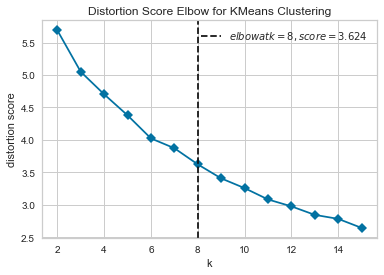

In [54]:
model_supercat = KElbowVisualizer(KMeans(random_state=0), k=15, timings=False)
model_supercat.fit(paris_grouped_clustering_supercat)
model_supercat.show()

In [55]:
# set number of clusters
kclusters = model_supercat.elbow_value_

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_grouped_clustering_supercat)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([3, 7, 3, 7, 7, 7, 0, 4, 7, 6, 7, 3, 1, 5, 7, 7, 7, 7, 7, 7, 5, 1,
       2, 7, 5, 3, 3, 2, 3, 7, 0, 4, 1, 7, 4, 3, 0, 5, 3, 1, 5, 7, 1, 6,
       2, 5, 1, 7, 5, 7, 1, 5, 1, 7, 7, 7, 7, 2, 5, 1, 2, 2, 1, 2, 1, 1,
       1, 2, 2, 4, 5, 1, 1, 1, 1, 2, 1, 1, 2, 7, 7, 1, 4, 3, 5, 2, 2, 5,
       5, 4, 1, 1, 3, 5, 7, 4, 7, 3, 3, 1])

In [56]:
# add clustering labels
neighborhoods_venues_sorted_supercat.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged_supercat = zip_paris

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged_supercat = paris_merged_supercat.join(neighborhoods_venues_sorted_supercat.set_index('Neighbourhood'), \
                                                   on='Name', how='right')

paris_merged_supercat # check the last columns!

,Name,Zip_Code,Latitude,Longitude,Department,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,PARIS 04,75004,48.854228282,2.35736193814,75,2,Other Restaurant/Cafe,French Restaurant,Nature Site,Bar,Shop,European Restaurant,Oriental Restaurant,Cultural Site,Asian Restaurant,Hotel
1,PARIS 07,75007,48.8560825982,2.31243868773,75,1,French Restaurant,Other Restaurant/Cafe,Hotel,Nature Site,Historic Site,Bar,European Restaurant,American Restaurant,Asian Restaurant,Food & Drink Shop
2,PARIS 11,75011,48.8594154976,2.37874106024,75,2,Other Restaurant/Cafe,Bar,French Restaurant,European Restaurant,Asian Restaurant,Oriental Restaurant,Cultural Site,American Restaurant,Food & Drink Shop,Shop
3,PARIS 15,75015,48.8401554186,2.29355937244,75,1,French Restaurant,Other Restaurant/Cafe,European Restaurant,Oriental Restaurant,Asian Restaurant,Hotel,Shop,Bar,Nature Site,Food & Drink Shop
4,PARIS 16,75116,48.8603987604,2.2620995594,75,1,French Restaurant,Other Restaurant/Cafe,Nature Site,Sports Site,European Restaurant,Asian Restaurant,Cultural Site,Food & Drink Shop,Transport,Historic Site
5,PARIS 20,75020,48.8631867774,2.40081982673,75,1,Bar,French Restaurant,Other Restaurant/Cafe,Cultural Site,Food & Drink Shop,Asian Restaurant,Sports Site,Oriental Restaurant,European Restaurant,American Restaurant
6,BOIS COLOMBES,92270,48.9153368426,2.26738552597,92,6,Food & Drink Shop,Asian Restaurant,French Restaurant,Nature Site,Other Restaurant/Cafe,Sports Site,Hotel,Transport,Office,Historic Site
7,BOULOGNE BILLANCOURT,92100,48.8365843138,2.23913599058,92,1,French Restaurant,Other Restaurant/Cafe,Asian Restaurant,European Restaurant,Shop,Oriental Restaurant,Food & Drink Shop,American Restaurant,Sports Site,Cultural Site
9,COURBEVOIE,92400,48.8984504771,2.25570587289,92,5,French Restaurant,Sports Site,Asian Restaurant,Food & Drink Shop,Nature Site,Hotel,European Restaurant,Other Restaurant/Cafe,Transport,Oriental Restaurant
10,LA GARENNE COLOMBES,92250,48.9067577111,2.24464604084,92,5,Asian Restaurant,French Restaurant,Other Restaurant/Cafe,Sports Site,Food & Drink Shop,European Restaurant,Office,Nature Site,Bar,Transport


In [57]:
latitude = paris_merged_supercat.loc[paris_merged_supercat['Name']=='PARIS 01','Latitude'].astype(float)
longitude = paris_merged_supercat.loc[paris_merged_supercat['Name']=='PARIS 01','Longitude'].astype(float)

# create map
map_clusters = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged_supercat['Latitude'].astype(float), paris_merged_supercat['Longitude'].astype(float), \
                                  paris_merged_supercat['Name'], paris_merged_supercat['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [58]:
paris_merged_supercat.loc[paris_merged_supercat['Cluster Labels'] == 0, \
                     paris_merged_supercat.columns[[0] + list(range(5, paris_merged_supercat.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
50,GENNEVILLIERS,0,Transport,Other Restaurant/Cafe,Hotel,Nature Site,Sports Site,Cultural Site,European Restaurant,American Restaurant,Asian Restaurant,Bar
70,BAGNEUX,0,Transport,Nature Site,Asian Restaurant,Sports Site,Food & Drink Shop,American Restaurant,Bar,Beauty,Cult Site,Cultural Site
107,LA COURNEUVE,0,Transport,Nature Site,Hotel,Sports Site,Shop,European Restaurant,American Restaurant,Asian Restaurant,Bar,Beauty


In [59]:
paris_merged_supercat.loc[paris_merged_supercat['Cluster Labels'] == 3, \
                     paris_merged_supercat.columns[[0] + list(range(5, paris_merged_supercat.shape[1]))]]

,Name,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,LE BOURGET,3,Transport,Shop,Nature Site,Food & Drink Shop,Other Restaurant/Cafe,Hotel,European Restaurant,Cultural Site,American Restaurant,Asian Restaurant
57,SEVRAN,3,Transport,Shop,Food & Drink Shop,European Restaurant,Other Restaurant/Cafe,Sports Site,American Restaurant,Asian Restaurant,Bar,Beauty
59,ALFORTVILLE,3,Shop,Transport,Other Restaurant/Cafe,Asian Restaurant,French Restaurant,Oriental Restaurant,Office,Sports Site,Food & Drink Shop,European Restaurant
62,CRETEIL,3,Shop,Other Restaurant/Cafe,Transport,Hotel,Food & Drink Shop,European Restaurant,Cultural Site,Oriental Restaurant,Nature Site,Bar
84,VILLEMOMBLE,3,Food & Drink Shop,Transport,Shop,Other Restaurant/Cafe,Asian Restaurant,Office,Nature Site,Hotel,European Restaurant,Cult Site
86,ARCUEIL,3,Shop,Other Restaurant/Cafe,Asian Restaurant,Transport,Nature Site,Food & Drink Shop,Hotel,Sports Site,Cultural Site,French Restaurant
119,THIAIS,3,Shop,Transport,Other Restaurant/Cafe,Nature Site,Sports Site,Asian Restaurant,Beauty,European Restaurant,French Restaurant,Historic Site
130,VILLENEUVE LA GARENNE,3,Shop,Transport,Food & Drink Shop,Other Restaurant/Cafe,Asian Restaurant,Nature Site,Hotel,Sports Site,European Restaurant,Cultural Site
134,EPINAY SUR SEINE,3,Shop,Other Restaurant/Cafe,Asian Restaurant,Transport,Cultural Site,American Restaurant,Nature Site,Hotel,Beauty,Sports Site
135,L ILE ST DENIS,3,Shop,Food & Drink Shop,Transport,Cult Site,Other Restaurant/Cafe,Nature Site,Hotel,Sports Site,European Restaurant,American Restaurant


The proposed clustering works just fine, but the clusters remain difficult to interpret. The above clustring does not take into account the total number of venues in each borough, however, when looking for a new place to live, this seems to be an important parameter to take into consideration. I thus propose to use a raw number of venues of each category instead of a proportion.

In [60]:
paris_sum = paris_onehot_supercat.groupby(['Neighbourhood']).sum().reset_index()
paris_sum.head()

,Neighbourhood,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,Food & Drink Shop,...,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
0,ALFORTVILLE,0,0,2,0,0,0,1,1,1,...,0,0,0,1,1,3,0,6,1,5
1,ANTONY,0,0,0,1,0,0,0,2,4,...,0,0,2,0,1,3,0,3,0,1
2,ARCUEIL,0,0,4,0,0,0,1,0,2,...,0,2,3,0,0,5,0,6,1,3
3,ASNIERES SUR SEINE,0,0,4,0,0,0,3,1,7,...,0,2,1,0,2,5,0,3,2,2
4,AUBERVILLIERS,0,0,0,0,0,0,1,0,3,...,0,0,2,0,0,3,0,2,4,2


In [61]:
paris_sum_clustering = paris_sum.drop(['Neighbourhood'], axis = 1)

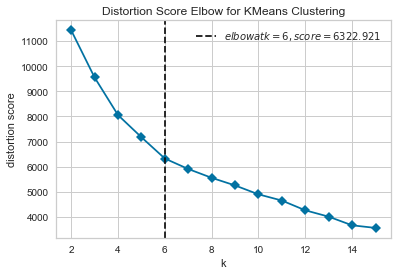

In [62]:
model_sum = KElbowVisualizer(KMeans(random_state=0), k=15, timings=False)
model_sum.fit(paris_sum_clustering)
model_sum.show()

This time, KElbowVisualizer does not encounter any problem finding an optimal number of clusters.

In [63]:
# set number of clusters
kclusters = model_sum.elbow_value_

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(paris_sum_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 5,
       0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 0, 5, 0, 5, 0, 5, 0, 0, 0, 0, 0, 3, 1, 1, 1, 4, 3, 4, 3,
       4, 1, 1, 0, 2, 4, 4, 5, 4, 1, 5, 5, 3, 0, 0, 0, 0, 0, 0, 0, 0, 5,
       0, 0, 5, 0, 0, 5, 0, 0, 0, 0, 0, 5])

In [64]:
# add clustering labels
paris_sum.insert(0, 'Cluster Labels', kmeans.labels_)

paris_merged_sum = zip_paris

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
paris_merged_sum = paris_merged_sum.join(paris_sum.set_index('Neighbourhood'), on='Name', how='right')

paris_merged_sum # check the last columns!

,Name,Zip_Code,Latitude,Longitude,Department,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,...,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
0,PARIS 04,75004,48.854228282,2.35736193814,75,1,0,1,4,12,...,1,3,13,0,6,19,0,10,1,0
1,PARIS 07,75007,48.8560825982,2.31243868773,75,4,0,3,3,6,...,7,11,10,0,0,20,0,0,0,0
2,PARIS 11,75011,48.8594154976,2.37874106024,75,1,0,4,6,16,...,0,1,2,0,5,28,0,3,2,0
3,PARIS 15,75015,48.8401554186,2.29355937244,75,4,0,0,11,5,...,0,9,4,0,11,15,0,5,3,0
4,PARIS 16,75116,48.8603987604,2.2620995594,75,5,0,0,4,1,...,1,1,9,0,1,10,0,0,5,3
5,PARIS 20,75020,48.8631867774,2.40081982673,75,5,0,1,3,15,...,1,1,1,1,2,7,0,1,3,1
6,BOIS COLOMBES,92270,48.9153368426,2.26738552597,92,0,0,0,3,0,...,0,1,2,0,0,2,0,0,1,1
7,BOULOGNE BILLANCOURT,92100,48.8365843138,2.23913599058,92,4,0,4,14,2,...,0,0,2,1,6,17,0,6,4,0
9,COURBEVOIE,92400,48.8984504771,2.25570587289,92,5,0,1,7,0,...,0,6,7,0,3,5,0,0,8,3
10,LA GARENNE COLOMBES,92250,48.9067577111,2.24464604084,92,0,0,0,7,1,...,0,0,2,2,1,4,0,1,3,1


In [65]:
latitude = paris_merged_sum.loc[paris_merged_sum['Name']=='PARIS 01','Latitude'].astype(float)
longitude = paris_merged_sum.loc[paris_merged_sum['Name']=='PARIS 01','Longitude'].astype(float)

# create map
map_clusters = folium.Map(location=[latitude.mean(), longitude.mean()], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(paris_merged_sum['Latitude'].astype(float), paris_merged_sum['Longitude'].astype(float), \
                                  paris_merged_sum['Name'], paris_merged_sum['Cluster Labels'].astype(int)):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Exploring the obtained clusters one by one
Cluster 0 (red) delineates residential areas with lots of shops and supermarkets but fewer restaurants, bars and cafés.

In [66]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 0, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,...,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
6,BOIS COLOMBES,0,0,0,3,0,0,0,0,0,...,0,1,2,0,0,2,0,0,1,1
10,LA GARENNE COLOMBES,0,0,0,7,1,0,0,0,2,...,0,0,2,2,1,4,0,1,3,1
13,RUEIL MALMAISON,0,0,0,0,1,0,0,0,0,...,1,0,2,0,0,0,0,0,0,2
14,SCEAUX,0,0,0,0,0,0,0,0,3,...,2,0,5,1,0,4,0,0,0,1
15,SEVRES,0,0,0,5,0,0,0,1,1,...,0,1,1,0,0,9,0,0,5,4
16,LE BOURGET,0,0,0,0,0,0,0,0,1,...,0,1,2,0,0,1,0,2,0,3
20,PANTIN,0,0,0,0,2,0,0,6,2,...,0,2,1,0,1,6,0,2,3,4
21,LES PAVILLONS SOUS BOIS,0,0,0,3,0,0,0,0,0,...,0,0,1,1,1,1,0,2,0,3
24,CHAMPIGNY SUR MARNE,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,2,0,2,1,1
26,FONTENAY SOUS BOIS,0,0,1,1,1,0,0,0,4,...,0,2,0,0,2,5,0,3,1,0


Cluster 1 (purple) is a night-life cluster.

In [72]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 1, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,...,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
0,PARIS 04,1,0,1,4,12,0,1,6,8,...,1,3,13,0,6,19,0,10,1,0
2,PARIS 11,1,0,4,6,16,0,0,5,11,...,0,1,2,0,5,28,0,3,2,0
37,PARIS 18,1,0,3,4,19,0,0,5,9,...,1,0,8,0,7,21,0,4,1,0
41,PARIS 10,1,0,2,13,7,0,0,0,11,...,0,4,2,0,11,28,0,4,2,0
42,PARIS 02,1,0,2,11,17,2,0,5,8,...,1,5,5,0,0,16,0,5,2,0
43,PARIS 03,1,0,5,8,9,1,0,10,4,...,0,4,3,0,6,30,0,11,0,0


Cluster 2 (blue) only has one district in it, and it is a curious one: it features 50 Asian restaurants.

In [68]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 2, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,...,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
36,PARIS 13,2,0,2,50,3,0,0,2,4,...,0,4,2,0,1,13,0,3,4,0


Cluster 3 (green) is my favourite one! In addition to French and non-geographic restaurants, has a lot of shops and natural sites, such as parks and gardens.

In [69]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 3, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,...,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
11,LEVALLOIS PERRET,3,0,5,7,5,0,0,1,8,...,0,6,4,0,4,19,0,9,5,0
34,PARIS 06,3,0,2,2,6,0,0,2,3,...,2,8,13,0,3,23,0,13,1,0
38,PARIS 01,3,0,0,18,6,1,1,7,4,...,3,5,12,0,1,13,0,13,2,1
44,PARIS 08,3,0,1,2,4,2,0,8,3,...,3,19,8,0,0,10,0,20,1,0
102,PUTEAUX,3,0,1,7,3,0,0,1,6,...,0,4,13,0,4,20,0,16,5,2


Cluster 4 (yellow) is a truly gastronomic cluster: it has lots of French and European restaurants, as well as non-geographic types of restaurants.

In [70]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 4, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,...,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
1,PARIS 07,4,0,3,3,6,0,0,1,6,...,7,11,10,0,0,20,0,0,0,0
3,PARIS 15,4,0,0,11,5,0,0,0,13,...,0,9,4,0,11,15,0,5,3,0
7,BOULOGNE BILLANCOURT,4,0,4,14,2,1,0,4,14,...,0,0,2,1,6,17,0,6,4,0
39,PARIS 05,4,0,3,8,7,1,0,7,11,...,2,4,5,0,4,20,0,4,1,0
40,PARIS 09,4,0,1,2,15,0,0,7,8,...,0,10,3,1,1,16,0,8,2,0
45,PARIS 14,4,0,1,12,6,0,0,3,10,...,1,11,2,0,3,18,0,3,1,0
47,PARIS 17,4,0,3,3,4,0,0,2,17,...,0,9,4,0,6,20,0,1,1,0


Cluster 5 (orange) seems to have a bit of every type of venue, such a happy mean. It also geographically delineates the Paris boundary and corresponds to the respectful suburbs.

In [73]:
paris_merged_sum.loc[paris_merged_sum['Cluster Labels'] == 5, \
                     paris_merged_sum.columns[[0] + list(range(5, paris_merged_sum.shape[1]))]]

,Name,Cluster Labels,Airport,American Restaurant,Asian Restaurant,Bar,Beauty,Cult Site,Cultural Site,European Restaurant,...,Historic Site,Hotel,Nature Site,Office,Oriental Restaurant,Other Restaurant/Cafe,Residence,Shop,Sports Site,Transport
4,PARIS 16,5,0,0,4,1,0,0,3,5,...,1,1,9,0,1,10,0,0,5,3
5,PARIS 20,5,0,1,3,15,0,1,4,2,...,1,1,1,1,2,7,0,1,3,1
9,COURBEVOIE,5,0,1,7,0,0,0,1,6,...,0,6,7,0,3,5,0,0,8,3
12,MALAKOFF,5,0,0,9,1,0,0,2,8,...,0,2,3,0,1,7,0,3,4,2
30,ST MANDE,5,0,1,9,1,0,0,0,5,...,1,2,5,0,1,7,0,0,5,3
48,PARIS 19,5,0,0,1,12,0,0,9,4,...,0,5,8,0,1,7,0,1,1,2
68,VINCENNES,5,0,3,6,2,0,0,2,6,...,1,5,3,2,0,13,0,3,3,0
74,NEUILLY SUR SEINE,5,0,1,5,1,0,0,2,7,...,0,2,9,0,0,10,0,1,2,0
124,CLICHY,5,0,0,6,0,1,0,0,12,...,0,11,3,0,1,9,0,1,4,1
125,ISSY LES MOULINEAUX,5,0,1,9,1,0,0,1,6,...,0,7,5,0,1,15,0,3,8,7
